In [58]:
!pip install Unidecode

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MaxNLocator

In [60]:
from tqdm import tqdm
import re
import string
import nltk
import unidecode 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [61]:
from textblob import TextBlob # WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [62]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Dataset From Kaggle

In [63]:
! pip install kaggle

In [64]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [65]:
! cp kaggle.json ~/.kaggle/

In [66]:
! chmod 600 ~/.kaggle/kaggle.json

In [67]:
! kaggle datasets download andrewmvd/trip-advisor-hotel-reviews

trip-advisor-hotel-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [68]:
!unzip trip-advisor-hotel-reviews.zip

Archive:  trip-advisor-hotel-reviews.zip
replace tripadvisor_hotel_reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: tripadvisor_hotel_reviews.csv  


# Data Exploration

In [69]:
original_reviews = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')

In [70]:
print(original_reviews.shape)

(20491, 2)


In [71]:
original_reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [72]:
original_reviews.isnull().sum()

Review    0
Rating    0
dtype: int64

In [73]:
original_reviews['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

<BarContainer object of 5 artists>

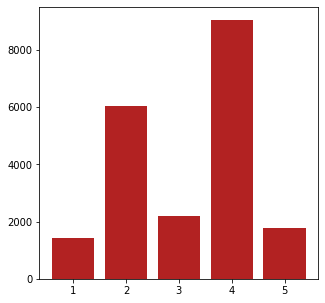

In [74]:
fig = plt.figure(figsize = (5, 5))
plt.bar(original_reviews.Rating.unique(),
        original_reviews['Rating'].value_counts(),
        color = 'firebrick')

**Convert the labels to Positive, Negative and Neutral.**

In [75]:
def Sentiment(rating):
    if rating <= 2:
        return 0
    elif rating >= 4:
        return 2
    else:
        return 1

In [76]:
original_reviews['Sentiment'] = original_reviews['Rating'].apply(Sentiment)
original_reviews.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


<BarContainer object of 3 artists>

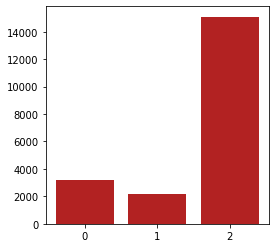

In [77]:
# plot the label distribution after the sentiment conversion
fig = plt.figure(figsize = (4, 4)).gca().xaxis.set_major_locator(MaxNLocator(integer = True))

plt.bar(original_reviews.Sentiment.unique(),
        original_reviews.Sentiment.value_counts(),
        color = 'firebrick')

Plot the reviews distributions, this might help in selecting the model and vectorizatio method.

In [78]:
def review_length(review_s):
    return len(review_s.split())

In [79]:
original_reviews['Length'] = original_reviews['Review'].apply(review_length)

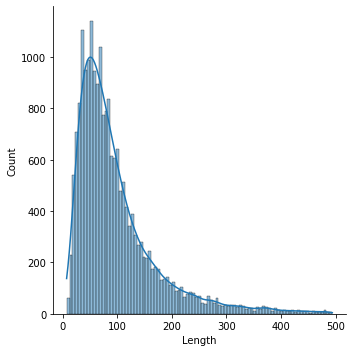

In [80]:
sns.displot(original_reviews[original_reviews['Length'] < 500].Length, kde=True)

# Text Preprocessing

In [81]:
punctuations_list = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')
urls = re.compile('http\S+')         # links regex

def remove_punctuations(text):
    translator = str.maketrans(' ', ' ', punctuations_list)
    return text.translate(translator)

def remove_newlines_tabs(text):
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return text

def remove_extra_spaces(text):
    r = re.findall("[ ]+", text)
    for i in r:
        text = re.sub(i, ' ', text)
    return text 

def remove_accented_characters(text):
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text)
    return text

def remove_special_characters(text):
    Formatted_Text = re.sub(r"[^a-zA-Z]+", ' ', text) 
    return Formatted_Text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_urls(text):
    text = re.sub(urls, '', text)
    return text

def to_lowercase(text):
    return text.lower()

def remove_stopwords(words, stopwords):
    return [word for word in words if word not in stopwords]

def text2words(text):
    return word_tokenize(text)

In [82]:
def normalize_text(text):
    text = remove_punctuations(text)
    text = remove_newlines_tabs(text)
    text = remove_urls(text)
    text = remove_repeating_char(text)
    text = remove_extra_spaces(text)
    text = remove_accented_characters(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)

    return ' '.join(words)

In [83]:
clean_reviews = original_reviews.copy()

In [84]:
clean_reviews

,Review,Rating,Sentiment,Length
0,nice hotel expensive parking got good deal sta...,4,2,87
1,ok nothing special charge diamond member hilto...,2,0,250
2,nice rooms not 4* experience hotel monaco seat...,3,1,217
3,"unique, great stay, wonderful time hotel monac...",5,2,89
4,"great stay great stay, went seahawk game aweso...",5,2,191
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,2,109
20487,great location price view hotel great quick pl...,4,2,39
20488,"ok just looks nice modern outside, desk staff ...",2,0,63
20489,hotel theft ruined vacation hotel opened sept ...,1,0,781


In [85]:
clean_reviews['Review'] = clean_reviews['Review'].apply(normalize_text)

Take a random sample from the data for the modeling to solve memory issues.

In [86]:
resampled_reviews = clean_reviews.sample(10000).copy()

In [87]:
resampled_reviews.Sentiment.value_counts()

2    7315
0    1613
1    1072
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

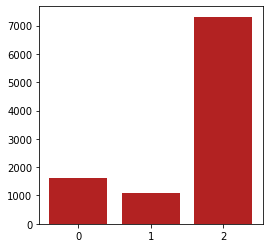

In [88]:
# to show only int numbers  
fig = plt.figure(figsize = (4, 4)).gca().xaxis.set_major_locator(MaxNLocator(integer = True))

plt.bar(resampled_reviews.Sentiment.unique(),
        resampled_reviews.Sentiment.value_counts(),
        color = 'firebrick')

## WordCloud

In [89]:
word_string = " ".join(review for review in original_reviews.Review)


wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', 
                      max_words=60000, 
                      width=1000,
                      height=650
                      ).generate(word_string)

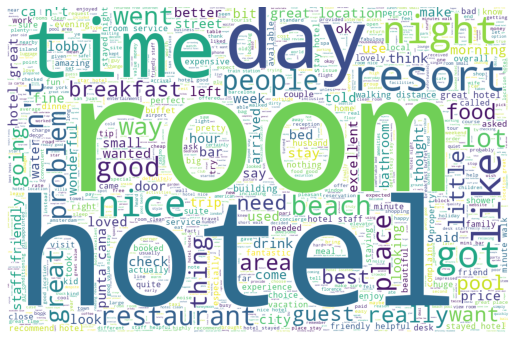

In [90]:
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# TF-IDF Vectorization

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(list(resampled_reviews.Review))

In [93]:
X = tfidf_vectorizer_vectors.toarray()
Y = resampled_reviews['Sentiment']

# Modeling

Split Data

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [110]:
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc


## Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)

print("Testing Accuracy score: "+str(round(accuracy_score(y_test,y_pred_test),4)))

Testing Accuracy score: 0.729


## Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)

print("Testing Accuracy score: "+str(round(accuracy_score(y_test,y_pred_test),4)))

Testing Accuracy score: 0.79


## Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)

print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Testing Accuracy score: 0.8405


Check Confusion Matrix for the highest score model

In [112]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.69      0.73       323
           1       0.45      0.10      0.16       214
           2       0.86      0.98      0.92      1463

    accuracy                           0.84      2000
   macro avg       0.70      0.59      0.60      2000
weighted avg       0.80      0.84      0.81      2000



## Bert

https://www.kaggle.com/charlessamuel/trip-advisor-hotel-reviews-bert

In [ ]:
!pip3 install ktrain

In [102]:
import ktrain
from ktrain import text

In [103]:
import tensorflow as tf

In [104]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(resampled_reviews, 
                                                                    'Review',
                                                                    label_columns=['Sentiment'],
                                                                    preprocess_mode='bert')

['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
17143          0.0          1.0          0.0
13494          0.0          0.0          1.0
7963           0.0          0.0          1.0
13754          0.0          1.0          0.0
3998           0.0          0.0          1.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
       Sentiment_0  Sentiment_1  Sentiment_2
6448           0.0          0.0          1.0
5490           0.0          0.0          1.0
19497          0.0          0.0          1.0
2726           1.0          0.0          0.0
297            0.0          0.0          1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc)

In [106]:
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=6)

In [107]:
learner.fit_onecycle(lr=2e-5,
                     epochs=1)



begin training using onecycle policy with max lr of 2e-05...
1500/1500 [==============================] - 1956s 1s/step - loss: 0.4848 - accuracy: 0.8219 - val_loss: 0.3407 - val_accuracy: 0.8770
